### Importing libraries

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
# from torchvision import datasets, transforms
import importlib
from torch_lr_finder import LRFinder
from utils import utils
from utils.utils import fabric
from utils.dataset import Dataset
from utils.scheduler import Scheduler
import warnings

warnings.filterwarnings('ignore')

In [15]:
# Initialize
utils.set_seed(1)

### Import dataset: CIFAR10

In [16]:
dataset = Dataset('CIFAR10', batch_size=512, trans_lib='albumentations')

# Add augmentations for training dataset
dataset.dt.set_transforms('train', [
    A.PadIfNeeded(min_height=40, min_width=40), #, always_apply=True
    A.RandomCrop(height=32, width=32), # , always_apply=True
    A.HorizontalFlip(),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=dataset.dt.mean)
], True)

Files already downloaded and verified
Files already downloaded and verified
The mean and SD for CIFAR10 dataset are [0.49139968 0.48215841 0.44653091] and [0.24703223 0.24348513 0.26158784] respectively.
Files already downloaded and verified
Files already downloaded and verified


In [17]:
train_loader, test_loader = dataset.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# from torchvision.datasets import CIFAR10
# from utils.dataset_override import CIFAR10_Override
# from albumentations.pytorch import ToTensorV2
# import numpy as np
# means = [0.4914, 0.4822, 0.4465]
# stds = [0.2470, 0.2435, 0.2616]

# m = np.array(means)*255
# train_transforms = A.Compose([
#     A.Normalize(mean=means, std=stds, always_apply=True),
#     A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
#     A.RandomCrop(height=32, width=32, always_apply=True),
#     A.HorizontalFlip(),
#     A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
#     ToTensorV2()
# ])
# train = CIFAR10_Override('../data', train=True, download=True, transform=train_transforms)
# train.trans_lib = 'albumentations'
# dataloader_cfgs = {
#     'batch_size': 512,
#     'shuffle': True,
#     'num_workers': 4,
#     'pin_memory': True
# }
# train_loader = torch.utils.data.DataLoader(train, **dataloader_cfgs)

In [19]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
torch.mean(images), torch.std(images), torch.min(images), torch.max(images)

(tensor(0.0366), tensor(0.9997), tensor(-1.9892), tensor(2.1268))

### Visualize input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

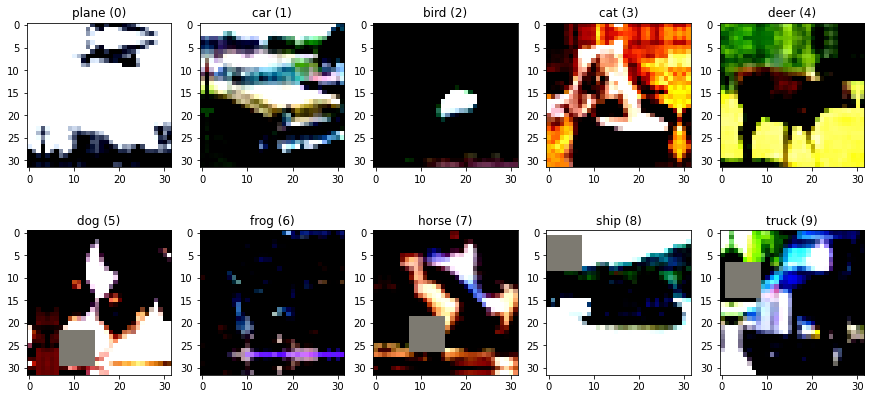

In [20]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# images, labels = next(dataiter)
utils.visualize_images(images, labels, label_mapper, n_cols=5, figsize=(15, 7))

### Model Training

In [21]:
from models import custom_resnet
importlib.reload(custom_resnet)

<module 'models.custom_resnet' from 'd:\\Self Learning\\TSAI\\TSAI\\S10\\models\\custom_resnet.py'>

In [22]:
from models.custom_resnet import CustomResNet
device = utils.get_device()
in_ch = 3
model_1 = CustomResNet(in_ch=in_ch).to(device)
summary(model_1, input_size=(in_ch, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.93E-02


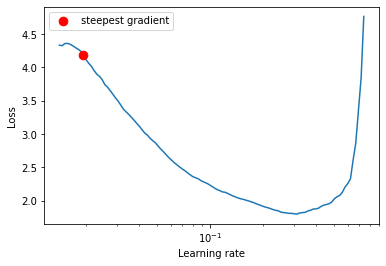

In [23]:
model = CustomResNet(in_ch=in_ch).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [24]:
num_epochs = 24
max_lr = 1.93E-02
steps_per_epoch = len(train_loader)

scheduler = Scheduler('OneCycleLR', {
    'optimizer': optimizer,
    'max_lr': max_lr,
    'steps_per_epoch': steps_per_epoch, 
    'epochs': num_epochs, 
    'pct_start': 5/num_epochs,
    'div_factor': 100,
    'final_div_factor': 100,
    'three_phase': False,
    'anneal_strategy': 'linear',
    'verbose': False
})

for epoch in range(1, num_epochs+1):
    print('EPOCH:', epoch)
    model.model_train(device, train_loader, criterion, optimizer, scheduler)
    model.model_test(device, test_loader, criterion)

EPOCH: 1


Train: Loss=1.1262261867523193 Batch_id=97 Accuracy=52.54: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Test: Average loss: 0.0022, Accuracy: 6282/10000 (62.82%), Accuracy Diff: 10.278

EPOCH: 2


Train: Loss=0.7925718426704407 Batch_id=97 Accuracy=68.98: 100%|██████████| 98/98 [00:57<00:00,  1.72it/s]


Test: Average loss: 0.0018, Accuracy: 6929/10000 (69.29%), Accuracy Diff: 0.306

EPOCH: 3


Train: Loss=0.7045766115188599 Batch_id=97 Accuracy=73.87: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]


Test: Average loss: 0.0016, Accuracy: 7268/10000 (72.68%), Accuracy Diff: 1.194

EPOCH: 4


Train: Loss=0.6800163984298706 Batch_id=97 Accuracy=76.82: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]


Test: Average loss: 0.0019, Accuracy: 7271/10000 (72.71%), Accuracy Diff: 4.112

EPOCH: 5


Train: Loss=0.7070159316062927 Batch_id=97 Accuracy=78.92: 100%|██████████| 98/98 [01:01<00:00,  1.59it/s]


Test: Average loss: 0.0016, Accuracy: 7448/10000 (74.48%), Accuracy Diff: 4.436

EPOCH: 6


Train: Loss=0.5752825736999512 Batch_id=97 Accuracy=81.11: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s] 


Test: Average loss: 0.0013, Accuracy: 7881/10000 (78.81%), Accuracy Diff: 2.296

EPOCH: 7


Train: Loss=0.5951784253120422 Batch_id=97 Accuracy=82.90: 100%|██████████| 98/98 [01:01<00:00,  1.60it/s] 


Test: Average loss: 0.0012, Accuracy: 8032/10000 (80.32%), Accuracy Diff: 2.584

EPOCH: 8


Train: Loss=0.5092517137527466 Batch_id=97 Accuracy=83.99: 100%|██████████| 98/98 [01:01<00:00,  1.59it/s] 


Test: Average loss: 0.0013, Accuracy: 7867/10000 (78.67%), Accuracy Diff: 5.322

EPOCH: 9


Train: Loss=0.41328921914100647 Batch_id=97 Accuracy=84.83: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]


Test: Average loss: 0.0014, Accuracy: 7659/10000 (76.59%), Accuracy Diff: 8.24

EPOCH: 10


Train: Loss=0.36499208211898804 Batch_id=97 Accuracy=85.48: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]


Test: Average loss: 0.0011, Accuracy: 8132/10000 (81.32%), Accuracy Diff: 4.156

EPOCH: 11


Train: Loss=0.5510779023170471 Batch_id=97 Accuracy=85.62: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s] 


Test: Average loss: 0.0010, Accuracy: 8251/10000 (82.51%), Accuracy Diff: 3.108

EPOCH: 12


Train: Loss=0.444413959980011 Batch_id=97 Accuracy=86.48: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]  


Test: Average loss: 0.0009, Accuracy: 8482/10000 (84.82%), Accuracy Diff: 1.664

EPOCH: 13


Train: Loss=0.4563882052898407 Batch_id=97 Accuracy=86.93: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s] 


Test: Average loss: 0.0010, Accuracy: 8293/10000 (82.93%), Accuracy Diff: 3.996

EPOCH: 14


Train: Loss=0.42819303274154663 Batch_id=97 Accuracy=87.39: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]


Test: Average loss: 0.0010, Accuracy: 8346/10000 (83.46%), Accuracy Diff: 3.926

EPOCH: 15


Train: Loss=0.3777291178703308 Batch_id=97 Accuracy=88.09: 100%|██████████| 98/98 [00:58<00:00,  1.69it/s] 


Test: Average loss: 0.0009, Accuracy: 8494/10000 (84.94%), Accuracy Diff: 3.148

EPOCH: 16


Train: Loss=0.33580490946769714 Batch_id=97 Accuracy=88.56: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test: Average loss: 0.0009, Accuracy: 8390/10000 (83.90%), Accuracy Diff: 4.662

EPOCH: 17


Train: Loss=0.35501664876937866 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]


Test: Average loss: 0.0008, Accuracy: 8706/10000 (87.06%), Accuracy Diff: 2.028

EPOCH: 18


Train: Loss=0.24977806210517883 Batch_id=97 Accuracy=90.15: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]


Test: Average loss: 0.0009, Accuracy: 8612/10000 (86.12%), Accuracy Diff: 4.03

EPOCH: 19


Train: Loss=0.38423436880111694 Batch_id=97 Accuracy=90.72: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]


Test: Average loss: 0.0007, Accuracy: 8732/10000 (87.32%), Accuracy Diff: 3.4

EPOCH: 20


Train: Loss=0.30703675746917725 Batch_id=97 Accuracy=91.94: 100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Test: Average loss: 0.0006, Accuracy: 8947/10000 (89.47%), Accuracy Diff: 2.474

EPOCH: 21


Train: Loss=0.22621944546699524 Batch_id=97 Accuracy=92.82: 100%|██████████| 98/98 [01:05<00:00,  1.50it/s]


Test: Average loss: 0.0006, Accuracy: 8979/10000 (89.79%), Accuracy Diff: 3.032

EPOCH: 22


Train: Loss=0.2352636605501175 Batch_id=97 Accuracy=93.89: 100%|██████████| 98/98 [01:02<00:00,  1.58it/s] 


Test: Average loss: 0.0006, Accuracy: 9074/10000 (90.74%), Accuracy Diff: 3.15

EPOCH: 23


Train: Loss=0.104766346514225 Batch_id=97 Accuracy=95.31: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]  


Test: Average loss: 0.0005, Accuracy: 9197/10000 (91.97%), Accuracy Diff: 3.342

EPOCH: 24


Train: Loss=0.0752536803483963 Batch_id=97 Accuracy=96.59: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s] 


Test: Average loss: 0.0005, Accuracy: 9262/10000 (92.62%), Accuracy Diff: 3.972



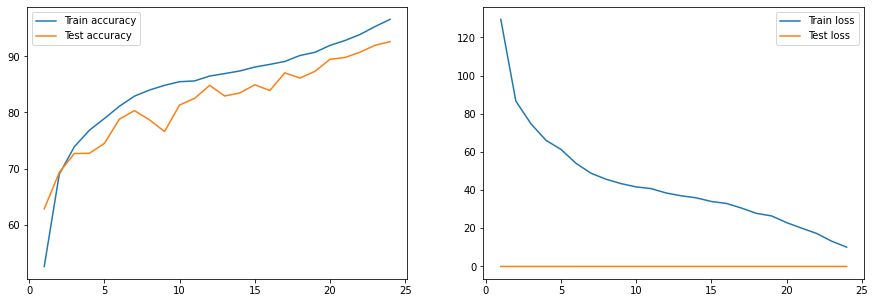

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
model.plot_accuracy()
plt.subplot(122)
model.plot_loss()
plt.savefig('images/model.png')
plt.show()

In [26]:
max(model.train_accuracy), max(model.test_accuracy)

(96.592, 92.62)

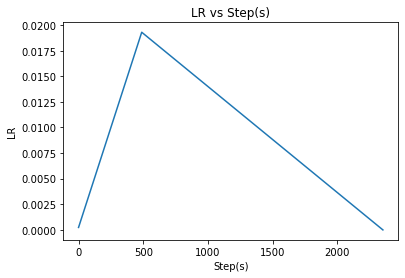

In [27]:
scheduler.plot_lr_change()

### Visualizing incorrect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

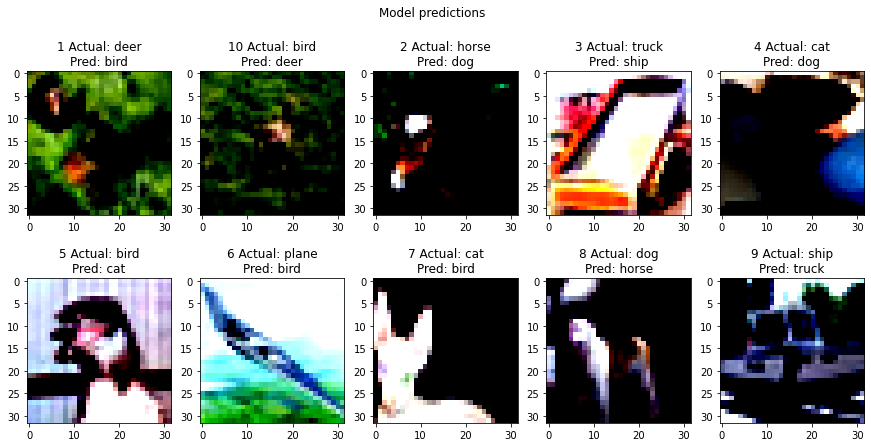

In [30]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, actual, pred = model.get_incorrect_pred(device, test_loader)
images, actual, pred = images.to('cpu'), actual.to('cpu'), pred.to('cpu')
labels = [str(indx + 1) + ' Actual: %s' % label_mapper[act.item()] + '\n' + \
    'Pred: %s' % label_mapper[pr.item()] for indx, (act, pr) in enumerate(zip(actual, pred))]
utils.visualize_images(images, labels, n_cols=5, figsize=(15, 7), img_title='Model predictions')
plt.savefig('images/incorrect_pred.png')